In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 1.1 Loading Data

In [2]:
import pandas
import pandas as pd
data = pandas.read_csv('/content/drive/MyDrive/aaic/preprocessed_data.csv')

In [3]:
data

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
...,...,...,...,...,...,...,...,...,...
109243,hi,mrs,grades_9_12,5,1,health_sports,teamsports,our day starts 100 students athletes low incom...,143.36
109244,nm,ms,grades_prek_2,3,1,appliedlearning,earlydevelopment other,my students range age four five years old atte...,268.57
109245,il,mrs,grades_3_5,0,1,math_science,appliedsciences environmentalscience,we title 1 school 650 total students our eleme...,399.00
109246,hi,mrs,grades_9_12,1,1,math_science,health_lifescience,i teach many different types students my class...,287.73


In [4]:
y=data['project_is_approved']

In [5]:
del data['project_is_approved']

In [6]:
x=data

<h2>Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [8]:
import numpy as np

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y, test_size=None, train_size=None, random_state=42, shuffle=True, stratify=y)


<h2> Making Data Model Ready: encoding essay, and project_title</h2>

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
essay_bag_train = vectorizer.fit_transform(x_train['essay'])
essay_bag_test=vectorizer.transform(x_test['essay'])

In [11]:
essay_bag_train.shape

(81936, 50440)

In [12]:
essay_bag_test.shape

(27312, 50440)

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
essay_tfidf_train = vectorizer.fit_transform(x_train['essay'])
essay_tfidf_test=vectorizer.transform(x_test['essay'])

In [14]:
essay_tfidf_train.shape

(81936, 50440)

In [15]:
x_train.head(2)

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
66441,ok,mr,grades_6_8,0,appliedlearning,charactereducation,my wonderful middle students active extremely ...,314.56
45954,ut,mrs,grades_prek_2,19,specialneeds,specialneeds,i teach special class children autism one stud...,33.28


<h2> Making Data Model Ready: encoding numerical, categorical features</h2>

In [16]:

from tqdm.notebook import tqdm
categorical=['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories']
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(binary=True)
categorical_train=dict()
categorical_test=dict()
for i in tqdm(categorical):
   categorical_train[i]= vectorizer.fit_transform(x_train[i])
   categorical_test[i]=vectorizer.transform(x_test[i])

  0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
from sklearn.preprocessing import Normalizer
transformer = Normalizer()
numerical_test=dict()
numerical_train=dict()
numerical=['teacher_number_of_previously_posted_projects','price']
for i in tqdm(numerical):
  numerical_train[i]=transformer.fit_transform(np.array(x_train[i]).reshape(1,-1))#.reshape(-1,1)
  numerical_test[i]=transformer.fit_transform(np.array(x_test[i]).reshape(1,-1))#.reshape(-1,1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [18]:
list(categorical_train.values())+[essay_bag_train]

[<81936x51 sparse matrix of type '<class 'numpy.int64'>'
 	with 81936 stored elements in Compressed Sparse Row format>,
 <81936x5 sparse matrix of type '<class 'numpy.int64'>'
 	with 81936 stored elements in Compressed Sparse Row format>,
 <81936x4 sparse matrix of type '<class 'numpy.int64'>'
 	with 81936 stored elements in Compressed Sparse Row format>,
 <81936x9 sparse matrix of type '<class 'numpy.int64'>'
 	with 114564 stored elements in Compressed Sparse Row format>,
 <81936x30 sparse matrix of type '<class 'numpy.int64'>'
 	with 132002 stored elements in Compressed Sparse Row format>,
 <81936x50440 sparse matrix of type '<class 'numpy.int64'>'
 	with 8848847 stored elements in Compressed Sparse Row format>]

In [19]:
from scipy.sparse import  hstack
u=hstack(list(categorical_train.values())+[essay_bag_train])

In [20]:
X=hstack([u,list(numerical_train.values())[0].reshape(-1,1),list(numerical_train.values())[1].reshape(-1,1)])

In [21]:
from scipy.sparse import  hstack
v=hstack(list(categorical_test.values())+[essay_bag_test])
X_test=hstack([v,list(numerical_test.values())[0].reshape(-1,1),list(numerical_test.values())[1].reshape(-1,1)])

In [22]:
essay_bag_test.shape

(27312, 50440)

In [23]:
essay_bag_train.shape

(81936, 50440)

In [24]:
X.shape

(81936, 50541)

In [25]:
y_train=np.array(y_train)

<h2>Appling NB</h2>

In [26]:
from sklearn.naive_bayes import MultinomialNB

In [27]:
X.shape

(81936, 50541)

In [28]:
y_train.shape

(81936,)

In [29]:
clf = MultinomialNB(class_prior=[0.5,0.5])
model=clf.fit(X,y_train)

In [30]:
bbb=model.predict(X_test)

In [31]:
from sklearn.metrics import roc_auc_score,auc
roc_auc_score(y_test,bbb)

0.6469449320279967

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
accuracy_score(bbb,y_test)

0.7401142355008787

In [35]:
#hyper paramater tuning 
from sklearn.model_selection import GridSearchCV
paramaters={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
model = MultinomialNB(class_prior=[0.5,0.5])
model_grid=GridSearchCV(model,paramaters,scoring='roc_auc',n_jobs=-1,return_train_score=True)
model_grid.fit(X,y_train)

GridSearchCV(estimator=MultinomialNB(class_prior=[0.5, 0.5]), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [36]:
auc_scores_train=model_grid.cv_results_['mean_train_score']
auc_scores_test=model_grid.cv_results_['mean_test_score']
params=model_grid.cv_results_['params']

In [37]:
auc_scores_train

array([0.90761128, 0.89921858, 0.90372343, 0.88812622, 0.89659429,
       0.86586894, 0.88304347, 0.8551026 , 0.81808353, 0.79632864,
       0.73248508, 0.68350302, 0.50004176, 0.5       ])

In [38]:
auc_scores_test

array([0.64142966, 0.66218815, 0.65272439, 0.67783257, 0.66668039,
       0.69334856, 0.68271642, 0.69698865, 0.69975413, 0.69755477,
       0.6779572 , 0.64758128, 0.50001154, 0.5       ])

In [39]:
paramaters_list=[]
from math import log
for i in params:
  paramaters_list.append(log(i['alpha']))

In [40]:
import  matplotlib.pyplot as plt

In [41]:
auc_scores_train

array([0.90761128, 0.89921858, 0.90372343, 0.88812622, 0.89659429,
       0.86586894, 0.88304347, 0.8551026 , 0.81808353, 0.79632864,
       0.73248508, 0.68350302, 0.50004176, 0.5       ])

In [42]:
paramaters_list

[-11.512925464970229,
 -7.600902459542082,
 -9.210340371976182,
 -5.298317366548036,
 -6.907755278982137,
 -2.995732273553991,
 -4.605170185988091,
 -2.3025850929940455,
 -0.6931471805599453,
 0.0,
 1.6094379124341003,
 2.302585092994046,
 3.912023005428146,
 4.605170185988092]

Text(0.5, 1.0, 'auc vs log(alpha)')

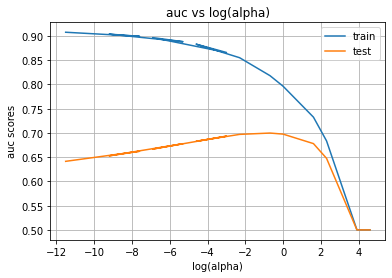

In [43]:
plt.plot(paramaters_list,auc_scores_train,label='train')
plt.plot(paramaters_list,auc_scores_test,label='test')
plt.legend()
plt.grid()
plt.xlabel('log(alpha)')
plt.ylabel('auc scores')
plt.title('auc vs log(alpha)')

In [44]:
optimal_alpha=pd.DataFrame(model_grid.cv_results_)[pd.DataFrame(model_grid.cv_results_)['mean_test_score']==pd.DataFrame(model_grid.cv_results_)['mean_test_score'].max()]['params'].iloc[0]['alpha']

In [45]:
model_grid.best_params_

{'alpha': 0.5}

In [46]:
print('optimal alpha is ',optimal_alpha)

optimal alpha is  0.5


In [47]:
clf = MultinomialNB(class_prior=[0.5,0.5],alpha=optimal_alpha)
model=clf.fit(X,y_train)

In [48]:
model.predict(X)

array([0, 1, 0, ..., 0, 1, 0])

In [49]:
model.predict(X_test)

array([0, 1, 1, ..., 1, 1, 0])

In [50]:
model.predict_proba(X)

array([[7.21774813e-01, 2.78225187e-01],
       [3.74551543e-01, 6.25448457e-01],
       [9.90399602e-01, 9.60039783e-03],
       ...,
       [7.70573228e-01, 2.29426772e-01],
       [1.71754584e-04, 9.99828245e-01],
       [9.89178358e-01, 1.08216415e-02]])

In [52]:
y_train

array([1, 1, 1, ..., 0, 1, 1])

In [53]:
probablities_model_test=model.predict_proba(X_test)
probablities_model_train=model.predict_proba(X)

In [54]:
probablities_model_train

array([[7.21774813e-01, 2.78225187e-01],
       [3.74551543e-01, 6.25448457e-01],
       [9.90399602e-01, 9.60039783e-03],
       ...,
       [7.70573228e-01, 2.29426772e-01],
       [1.71754584e-04, 9.99828245e-01],
       [9.89178358e-01, 1.08216415e-02]])

In [55]:
probablities_model_test

array([[9.82609506e-01, 1.73904942e-02],
       [1.58503765e-01, 8.41496235e-01],
       [1.32810026e-02, 9.86718997e-01],
       ...,
       [2.38584158e-01, 7.61415842e-01],
       [2.22262387e-05, 9.99977774e-01],
       [9.63911315e-01, 3.60886846e-02]])

In [57]:
y_train.reshape(-1,1).shape

(81936, 1)

In [58]:

np.array(y_test).reshape(-1,1)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [59]:
train_probablities_model=list(map(lambda x:x[1],probablities_model_train))
test_probablities_model=list(map(lambda x:x[1],probablities_model_test))

In [60]:
len(y_train)

81936

In [61]:
len(train_probablities_model)

81936

In [62]:
# Ploting the ROC-AUC curves using the probability predictions made on train and test data.
from sklearn import metrics
fpr_train, tpr_train, thresholds_train= metrics.roc_curve(y_train,train_probablities_model)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test,test_probablities_model)

In [63]:
roc_auc_score(y_test,test_probablities_model)

0.7105888257144555

In [64]:
from sklearn.metrics import auc

Text(0.5, 1.0, 'tpr/fpr')

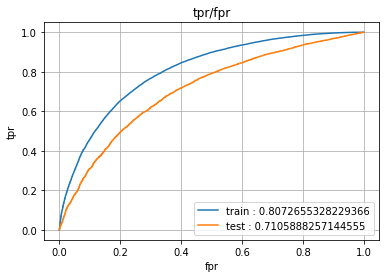

In [65]:
plt.plot(fpr_train,tpr_train,label=f'train : {auc(fpr_train,tpr_train)}')
plt.plot(fpr_test,tpr_test,label=f'test : {auc(fpr_test,tpr_test)}')
plt.legend()
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid()
plt.title('tpr/fpr')

In [67]:
count_train=0
thres_train=0
for i in range(len(fpr_train)):
  if tpr_train[i]*(1-fpr_train[i])>count_train:
    count_train=tpr_train[i]*(1-fpr_train[i])
    thres_train=thresholds_train[i]
count_test=0
thres_test=0
for i in range(len(fpr_test)):
  if tpr_test[i]*(1-fpr_test[i])>count_test:
    count_test=tpr_test[i]*(1-fpr_test[i])
    thres_test=thresholds_test[i]

In [68]:
#best threshold according to TPR*(1-FPR) for train data
thres_train

0.5484401129171619

In [69]:
tpr_train

array([0.        , 0.0015389 , 0.00155329, ..., 0.99998562, 1.        ,
       1.        ])

In [70]:
train_values_proba=[]

for i in range(len(train_probablities_model)):
  if train_probablities_model[i]>=thres_train:
    train_values_proba.append(1)
  else:
    train_values_proba.append(0)

test_values_proba=[]

for i in range(len(test_probablities_model)):
  if test_probablities_model[i]>=thres_train:
    test_values_proba.append(1)
  else:
    test_values_proba.append(0)



In [71]:
thres_train

0.5484401129171619

In [72]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_train,train_values_proba)
cm_test=confusion_matrix(y_test,test_values_proba)

In [73]:
cm_train

array([[ 8937,  3469],
       [17510, 52020]])

In [74]:
cm_test

array([[ 2427,  1709],
       [ 6302, 16874]])

Text(0.5, 1.0, 'confusion matrix for training data')

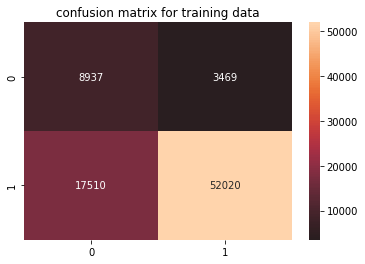

In [75]:
# Ploting the confusion matrices(each for train and test data) afer encoding the predicted class labels, on the basis of the best threshod probability estimate.
import seaborn as sns
sns.heatmap(cm_train, annot=True,fmt="d",center=True)
plt.title('confusion matrix for training data')

Text(0.5, 1.0, 'confusion matrix for test data')

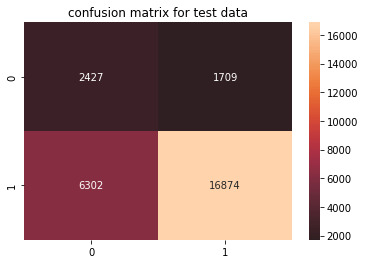

In [76]:
sns.heatmap(cm_test, annot=True,fmt="d",center=True)
plt.title('confusion matrix for test data')

### Hstack TFIDF Vectorizer feature to the original dataset and checking if the model performance increases

In [78]:
from scipy.sparse import  hstack
u=hstack(list(categorical_train.values())+[essay_tfidf_train])

In [79]:
X=hstack([u,list(numerical_train.values())[0].reshape(-1,1),list(numerical_train.values())[1].reshape(-1,1)])

In [80]:
from scipy.sparse import  hstack
v=hstack(list(categorical_test.values())+[essay_tfidf_test])
X_test=hstack([v,list(numerical_test.values())[0].reshape(-1,1),list(numerical_test.values())[1].reshape(-1,1)])

In [81]:
X_test.shape

(27312, 50541)

In [82]:
essay_tfidf_test.shape

(27312, 50440)

In [83]:
X.shape

(81936, 50541)

In [84]:
X.shape

(81936, 50541)

In [85]:
y_train=np.array(y_train)

In [86]:
from sklearn.naive_bayes import MultinomialNB

In [87]:
clf = MultinomialNB(class_prior=[0.5,0.5])
model=clf.fit(X,y_train)

In [88]:
bbb=model.predict(X_test)

In [89]:
from sklearn.metrics import accuracy_score

In [90]:
accuracy_score(bbb,y_test)

0.8424502050380785

In [91]:
#hyper paramater tuning 
from sklearn.model_selection import GridSearchCV
paramaters={'alpha':[0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]}
model = MultinomialNB(class_prior=[0.5,0.5])
model_grid=GridSearchCV(model,paramaters,scoring='roc_auc',n_jobs=-1,return_train_score=True)
model_grid.fit(X,y_train)

GridSearchCV(estimator=MultinomialNB(class_prior=[0.5, 0.5]), n_jobs=-1,
             param_grid={'alpha': [1e-05, 0.0005, 0.0001, 0.005, 0.001, 0.05,
                                   0.01, 0.1, 0.5, 1, 5, 10, 50, 100]},
             return_train_score=True, scoring='roc_auc')

In [92]:
auc_scores_train=model_grid.cv_results_['mean_train_score']
auc_scores_test=model_grid.cv_results_['mean_test_score']
params=model_grid.cv_results_['params']

In [93]:
auc_scores_train

array([0.90928349, 0.90051177, 0.90569314, 0.88378778, 0.89704779,
       0.83461728, 0.87432105, 0.80621617, 0.71920635, 0.67795234,
       0.59307882, 0.5701336 , 0.54137779, 0.53454649])

In [94]:
auc_scores_test

array([0.61601785, 0.63843234, 0.62750379, 0.65701401, 0.64381052,
       0.66827145, 0.66230588, 0.66566318, 0.64233266, 0.62439355,
       0.57522447, 0.55954358, 0.53770209, 0.53204424])

In [95]:
paramaters_list=[]
from math import log
for i in params:
  paramaters_list.append(log(i['alpha']))

In [96]:
import  matplotlib.pyplot as plt

In [97]:
auc_scores_train

array([0.90928349, 0.90051177, 0.90569314, 0.88378778, 0.89704779,
       0.83461728, 0.87432105, 0.80621617, 0.71920635, 0.67795234,
       0.59307882, 0.5701336 , 0.54137779, 0.53454649])

In [98]:
paramaters_list

[-11.512925464970229,
 -7.600902459542082,
 -9.210340371976182,
 -5.298317366548036,
 -6.907755278982137,
 -2.995732273553991,
 -4.605170185988091,
 -2.3025850929940455,
 -0.6931471805599453,
 0.0,
 1.6094379124341003,
 2.302585092994046,
 3.912023005428146,
 4.605170185988092]

Text(0.5, 1.0, 'auc vs log(alpha)')

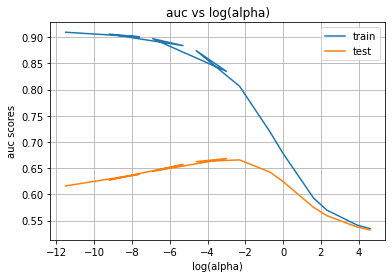

In [99]:
# Ploting the training and the CV AUC scores, for different values of 'alpha', using a 2D line plot

plt.plot(paramaters_list,auc_scores_train,label='train')
plt.plot(paramaters_list,auc_scores_test,label='test')
plt.legend()
plt.grid()
plt.xlabel('log(alpha)')
plt.ylabel('auc scores')
plt.title('auc vs log(alpha)')

In [100]:
optimal_alpha=pd.DataFrame(model_grid.cv_results_)[pd.DataFrame(model_grid.cv_results_)['mean_test_score']==pd.DataFrame(model_grid.cv_results_)['mean_test_score'].max()]['params'].iloc[0]['alpha']

In [101]:
model_grid.best_params_

{'alpha': 0.05}

In [102]:
print('optimal alpha is ',optimal_alpha)

optimal alpha is  0.05


In [103]:
clf = MultinomialNB(class_prior=[0.5,0.5],alpha=optimal_alpha)
model=clf.fit(X,y_train)

In [104]:
model.predict(X)

array([0, 0, 0, ..., 0, 1, 0])

In [105]:
model.predict(X_test)

array([0, 1, 1, ..., 0, 1, 0])

In [106]:
model.predict_proba(X)

array([[0.57102277, 0.42897723],
       [0.51348906, 0.48651094],
       [0.67926618, 0.32073382],
       ...,
       [0.65257507, 0.34742493],
       [0.27426401, 0.72573599],
       [0.52773323, 0.47226677]])

In [107]:
({'probablities given by model':model.predict_proba(X),'class label':y_train})

{'class label': array([1, 1, 1, ..., 0, 1, 1]),
 'probablities given by model': array([[0.57102277, 0.42897723],
        [0.51348906, 0.48651094],
        [0.67926618, 0.32073382],
        ...,
        [0.65257507, 0.34742493],
        [0.27426401, 0.72573599],
        [0.52773323, 0.47226677]])}

In [108]:
y_train

array([1, 1, 1, ..., 0, 1, 1])

In [109]:
probablities_model_test=model.predict_proba(X_test)
probablities_model_train=model.predict_proba(X)

In [110]:
probablities_model_train

array([[0.57102277, 0.42897723],
       [0.51348906, 0.48651094],
       [0.67926618, 0.32073382],
       ...,
       [0.65257507, 0.34742493],
       [0.27426401, 0.72573599],
       [0.52773323, 0.47226677]])

In [111]:
probablities_model_test

array([[0.6883992 , 0.3116008 ],
       [0.37638354, 0.62361646],
       [0.34917541, 0.65082459],
       ...,
       [0.55863973, 0.44136027],
       [0.28649303, 0.71350697],
       [0.59065654, 0.40934346]])

In [112]:
y_train.reshape(-1,1).shape

(81936, 1)

In [113]:
np.array(y_test).reshape(-1,1)

array([[1],
       [1],
       [1],
       ...,
       [1],
       [1],
       [0]])

In [114]:
train_probablities_model=list(map(lambda x:x[1],probablities_model_train))
test_probablities_model=list(map(lambda x:x[1],probablities_model_test))

In [115]:
len(y_train)

81936

In [116]:
len(train_probablities_model)

81936

In [117]:
# Ploting the ROC-AUC curves using the probability predictions made on train and test data.
from sklearn import metrics
from sklearn.metrics import auc
fpr_train, tpr_train, thresholds_train= metrics.roc_curve(y_train,train_probablities_model)
fpr_test, tpr_test, thresholds_test = metrics.roc_curve(y_test,test_probablities_model)

Text(0.5, 1.0, 'tpr/fpr')

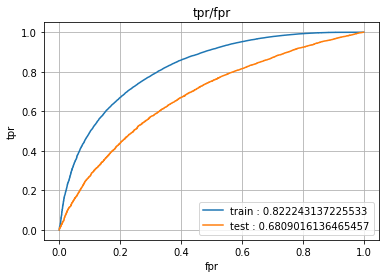

In [118]:
plt.plot(fpr_train,tpr_train,label=f'train : {auc(fpr_train,tpr_train)}')
plt.plot(fpr_test,tpr_test,label=f'test : {auc(fpr_test,tpr_test)}')
plt.legend()
plt.ylabel('tpr')
plt.xlabel('fpr')
plt.grid()
plt.title('tpr/fpr')

In [119]:
f'train : {auc(fpr_train,tpr_train)}'

'train : 0.822243137225533'

In [120]:
count_train=0
thres_train=0
for i in range(len(fpr_train)):
  if tpr_train[i]*(1-fpr_train[i])>count_train:
    count_train=tpr_train[i]*(1-fpr_train[i])
    thres_train=thresholds_train[i]
count_test=0
thres_test=0
for i in range(len(fpr_test)):
  if tpr_test[i]*(1-fpr_test[i])>count_test:
    count_test=tpr_test[i]*(1-fpr_test[i])
    thres_test=thresholds_test[i]

In [121]:
tpr_train

array([0.00000000e+00, 1.43822810e-05, 4.57356537e-03, ...,
       9.99985618e-01, 1.00000000e+00, 1.00000000e+00])

In [122]:
#best threshold according to TPR*(1-FPR) for train data
thres_train

0.5111097900493313

In [123]:
train_values_proba=[]

for i in range(len(train_probablities_model)):
  if train_probablities_model[i]>=thres_train:
    train_values_proba.append(1)
  else:
    train_values_proba.append(0)

test_values_proba=[]

for i in range(len(test_probablities_model)):
  if test_probablities_model[i]>=thres_train:
    test_values_proba.append(1)
  else:
    test_values_proba.append(0)



In [124]:
from sklearn.metrics import confusion_matrix
cm_train=confusion_matrix(y_train,train_values_proba)
cm_test=confusion_matrix(y_test,test_values_proba)

In [125]:
cm_train

array([[ 9196,  3210],
       [18055, 51475]])

In [126]:
cm_test

array([[ 2300,  1836],
       [ 6798, 16378]])

Text(0.5, 1.0, 'confusion matrix for training data')

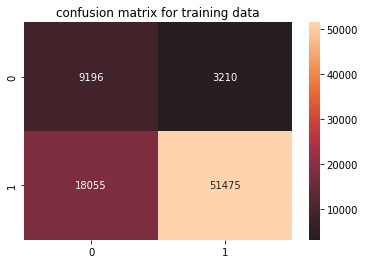

In [127]:
import seaborn as sns
sns.heatmap(cm_train, annot=True,fmt="d",center=True)
plt.title('confusion matrix for training data')

Text(0.5, 1.0, 'confusion matrix for test data')

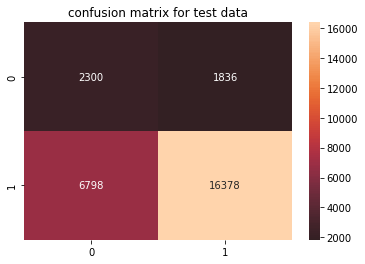

In [128]:
sns.heatmap(cm_test, annot=True,fmt="d",center=True)
plt.title('confusion matrix for test data')

In [133]:
all_features=[]
for i in (categorical+['essay']):
  vectorizer = CountVectorizer(binary=True)
  vectorizer.fit(x_train[i])
  all_features.extend(list(vectorizer.get_feature_names()))
  print(len(list(vectorizer.get_feature_names())))
all_features.extend(numerical)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


51
5
4
9
30
50440


In [134]:
#top 20 features for negative class
print("TOP FEATURES FOR NEGATIVE CLASS".center(100,'#'),end='\n\n')
for i in range(1,20):
  print(np.array(all_features)[np.argsort(model.feature_log_prob_[0])[-i]])

##################################TOP FEATURES FOR NEGATIVE CLASS###################################

mrs
literacy_language
grades_prek_2
math_science
ms
grades_3_5
mathematics
literacy
literature_writing
grades_6_8
specialneeds
specialneeds
health_sports
ca
students
appliedlearning
appliedsciences
grades_9_12
mr


In [135]:
#top 20 features for negative class
print("TOP FEATURES FOR POSITIVE CLASS".center(100,'#'),end='\n\n')
for i in range(1,20):
  print(np.array(all_features)[np.argsort(model.feature_log_prob_[1])[-i]])

##################################TOP FEATURES FOR POSITIVE CLASS###################################

mrs
literacy_language
grades_prek_2
math_science
ms
grades_3_5
literacy
mathematics
literature_writing
grades_6_8
ca
health_sports
students
specialneeds
specialneeds
appliedlearning
grades_9_12
mr
appliedsciences


<h1>Summary</h1>

In [137]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names=['vectorizer','hyper parameter','AUC']
x.add_row(['bow',0.05,0.71])
x.add_row(['Tfidf',0.05,0.68])
print(x)

+------------+-----------------+------+
| vectorizer | hyper parameter | AUC  |
+------------+-----------------+------+
|    bow     |       0.05      | 0.71 |
|   Tfidf    |       0.05      | 0.68 |
+------------+-----------------+------+
